In [13]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import math
import chardet
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import heapq
import re
import plotnine
import copy
import pydot
import graphviz
from graphviz import Source
from scipy.stats import randint as sp_randint
from sklearn.linear_model import LinearRegression, LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols, logit 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFECV, RFE
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import export_graphviz
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from IPython.display import display
from pprint import pprint

In [2]:
# Importing processed data into notebook

sourcepath = 'D:\Work\Research\Dropbox\Machine Learning\Side Projects\Employee Churn IBM\employee_churn_prediction_ibm'
datapath = os.path.join(sourcepath, 'data','processed','IBM_HR_Data_Cleaned.csv')

IBMData = pd.read_csv(datapath)

In [3]:
# Dropping irrelevant variables

IBMData.drop(['EmployeeNumber'], axis = 1, inplace = True)

In [4]:
# Changing the types of some variables 

numvars = ['Age','DailyRate','DistanceFromHome','HourlyRate','MonthlyIncome','MonthlyRate','NumCompaniesWorked', 
          'PercentSalaryHike','PerformanceRating','TotalWorkingYears','TrainingTimesLastYear','YearsAtCompany',
          'YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager']
newnumvars = ['Education','EnvironmentSatisfaction','JobInvolvement','JobLevel','JobSatisfaction','PerformanceRating',
              'RelationshipSatisfaction','StockOptionLevel','WorkLifeBalance']
catvars = [item for item in IBMData.columns.to_list() if item not in numvars and item not in newnumvars and item != 'Attrition']

In [5]:
IBMData[numvars] = IBMData[numvars].apply(pd.to_numeric, axis = 1, downcast = 'float')
IBMData[newnumvars] = IBMData[newnumvars].apply(pd.to_numeric, axis = 1, downcast = 'float')
IBMData[catvars] = IBMData[catvars].astype('category')

In [6]:
# Now rename some of the categorical variable levels

IBMData['BusinessTravel'].cat.rename_categories(
        {'Travel_Rarely':'Rare','Travel_Frequently':'Freq','Non-Travel':'No'}, inplace = True)
IBMData['Department'].cat.rename_categories(
    {'Research & Development':'R&D','Sales':'Sales','Human Resources':'HR'}, inplace = True)
IBMData['EducationField'].cat.rename_categories(
    {'Life Sciences':'LifeSc','Technical Degree':'Technical','Human Resources':'EducHR'}, inplace = True)
IBMData['JobRole'].cat.rename_categories(
    {'Sales Executive':'SalexExec','Research Scientist':'Scientist','Laboratory Technician':'LabTech',
    'Manufacturing Director':'ManufDir','Healthcare Representative':'HealthRep','Sales Representative':'SalesRep',
    'Research Director':'ResDir','Human Resources':'RoleHR'}, inplace = True)

In [7]:
# Now re-categorize the Attrition (outcome) variable from object to int

exit_status_map = {'Yes':1, 'No':0}
IBMData['Attrition'] = IBMData['Attrition'].map(exit_status_map)

In [8]:
# Now check the data types of the columns

#IBMData.dtypes

In [9]:
# Now generate a new dataframe and then separate the predictors from outcome, and encode the dummies

IBMDataNew = IBMData.copy(deep = True)
IBMDataNewLabel = IBMDataNew['Attrition'].copy(deep = True)
IBMDataNew.drop(['Attrition'], axis = 1, inplace = True)
IBMDataNew = pd.get_dummies(IBMDataNew)

In [10]:
# Now check some of the characteristics of the datasets created and the initial dataset

print('Size of the initial data frame: {}'.format(IBMData.shape))
print('Size of the new data frame with predictors: {}'.format(IBMDataNew.shape))
print('Size of the new data frame with labels: {}'.format(len(IBMDataNewLabel)))
print('\nVariable Names in initial data frame: ', IBMData.columns.to_list())
print('\nVariance Names in new data frame with predictors: ', IBMDataNew.columns.to_list())

Size of the initial data frame: (1470, 31)
Size of the new data frame with predictors: (1470, 51)
Size of the new data frame with labels: 1470

Variable Names in initial data frame:  ['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

Variance Names in new data frame with predictors:  ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSa

In [11]:
# Now we split the data into training and test sets

seed = 50
Xtrain, Xtest, Ytrain, Ytest = train_test_split(IBMDataNew, IBMDataNewLabel, test_size = 0.25, random_state = seed)

# Now show some of the characteristics of the test and train sets
print('Shapes of train and test predictors sets respectively are: ', Xtrain.shape, Xtest.shape)
print('Size of train and test labels respectively are: ', len(Ytrain), len(Ytest))
print('\nProportion of exits in train and test sets respectively: ', round(sum(Ytrain)/len(Ytrain),3), round(sum(Ytest)/len(Ytest),3))

# Now split the main data as well by using the index of the train and test sets
IBMData_train = IBMData.loc[Xtrain.index,:].copy(deep = True)
IBMData_test = IBMData.loc[Xtest.index,:].copy(deep = True)

Shapes of train and test predictors sets respectively are:  (1102, 51) (368, 51)
Size of train and test labels respectively are:  1102 368

Proportion of exits in train and test sets respectively:  0.161 0.163


### Simple Gradient Boosting Classifier

In [14]:
scaler = StandardScaler()
XtrainNew = scaler.fit(Xtrain).transform(Xtrain)
XtestNew = scaler.fit(Xtest).transform(Xtest)

In [15]:
seed = 50

est = GradientBoostingClassifier(learning_rate = 0.01, n_estimators = 200, 
                                 random_state = seed, verbose = 0, validation_fraction = 0.2)

est.fit(XtrainNew, Ytrain)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200,
                           random_state=50, validation_fraction=0.2)

In [20]:
Ypred = est.predict(XtestNew)

Accuracy of prediction: 84.783%
Precision of prediction: 83.333%
Recall of prediction: 8.333%
F1 Score of prediction: 0.152
ROC-AUC Score of prediction: 0.54


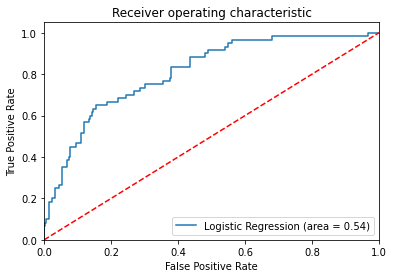

In [21]:
print('Accuracy of prediction: {:2.3%}'.format(accuracy_score(Ytest, Ypred)))
print('Precision of prediction: {:2.3%}'.format(precision_score(Ytest, Ypred)))
print('Recall of prediction: {:2.3%}'.format(recall_score(Ytest, Ypred)))
print('F1 Score of prediction: {:1.3}'.format(f1_score(Ytest, Ypred)))
print('ROC-AUC Score of prediction: {:1.3}'.format(roc_auc_score(Ytest, Ypred)))

# Now plot the roc_auc_curve
fpr, tpr, threshold = roc_curve(Ytest, est.predict_proba(XtestNew)[:,1])

plt.figure()
plt.plot(fpr, tpr, label = 'Logistic Regression (area = %0.2f)' % roc_auc_score(Ytest, Ypred))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [27]:
## Now implement GradientBoostingClassifier along with GridSearchCV

param_grid = {'learning_rate':np.logspace(-4,1,2), 
             'n_estimators':np.arange(100, 510, 100),
             'criterion':['friedman_mse', 'mse'],
             'max_depth':np.arange(2,4),
             'max_features':['auto','sqrt','log2']}

gbc = GradientBoostingClassifier(random_state = seed, verbose = 0)
gbc_best = GridSearchCV(gbc, param_grid, cv = 3, scoring = 'roc_auc')

In [28]:
gbc_best.fit(XtrainNew, Ytrain)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=50),
             param_grid={'criterion': ['friedman_mse', 'mse'],
                         'learning_rate': array([1.e-04, 1.e+01]),
                         'max_depth': array([2, 3]),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': array([100, 200, 300, 400, 500])},
             scoring='roc_auc')

In [29]:
for attr in dir(gbc_best):
    print(attr)


__abstractmethods__
__class__
__delattr__
__dict__
__dir__
__doc__
__eq__
__format__
__ge__
__getattribute__
__getstate__
__gt__
__hash__
__init__
__init_subclass__
__le__
__lt__
__module__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__setstate__
__sizeof__
__str__
__subclasshook__
__weakref__
_abc_impl
_check_is_fitted
_check_n_features
_estimator_type
_format_results
_get_param_names
_get_tags
_more_tags
_pairwise
_repr_html_
_repr_html_inner
_repr_mimebundle_
_required_parameters
_run_search
_validate_data
best_estimator_
best_index_
best_params_
best_score_
classes_
cv
cv_results_
decision_function
error_score
estimator
fit
get_params
iid
inverse_transform
multimetric_
n_features_in_
n_jobs
n_splits_
param_grid
pre_dispatch
predict
predict_log_proba
predict_proba
refit
refit_time_
return_train_score
score
scorer_
scoring
set_params
transform
verbose


In [30]:
print(gbc_best.best_params_)

{'criterion': 'friedman_mse', 'learning_rate': 0.0001, 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 100}


In [31]:
Ypred = gbc_best.predict(XtestNew)

Accuracy of prediction: 83.696%
Precision of prediction: 0.000%
Recall of prediction: 0.000%
F1 Score of prediction: 0.0
ROC-AUC Score of prediction: 0.5


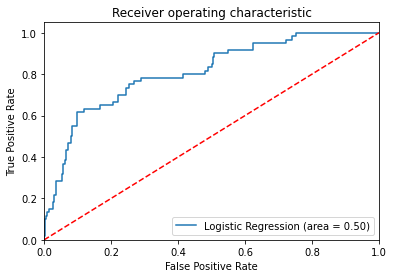

In [32]:
print('Accuracy of prediction: {:2.3%}'.format(accuracy_score(Ytest, Ypred)))
print('Precision of prediction: {:2.3%}'.format(precision_score(Ytest, Ypred)))
print('Recall of prediction: {:2.3%}'.format(recall_score(Ytest, Ypred)))
print('F1 Score of prediction: {:1.3}'.format(f1_score(Ytest, Ypred)))
print('ROC-AUC Score of prediction: {:1.3}'.format(roc_auc_score(Ytest, Ypred)))

# Now plot the roc_auc_curve
fpr, tpr, threshold = roc_curve(Ytest, gbc_best.predict_proba(XtestNew)[:,1])

plt.figure()
plt.plot(fpr, tpr, label = 'Logistic Regression (area = %0.2f)' % roc_auc_score(Ytest, Ypred))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()